# **Sebastian Ramos and Tomas Vera Audio Tempo Detection Project**

Mini Project 2: - Tempo Estimation for Musical Audio Signals

In this project, we wrote a Python program that analyzes music recordings and reports their tempo, in beats per minute. We are provided with a dataset for this purpose which contains audio files alongside human-annotated tempo values. We implemented our own tempo detection engine first. Then we also computed each file's tempo using the librosa library. Finally we compare the accuracy of our tempo impementation using the human-annotated tempo data as well as the calculated tempo by the librosa library.

Project datafiles provided by Yon Visell

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import essentia.standard as es
import IPython as ipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 4.7 MB/s 


# Tempo Detection (Our Implementation)

Display all of the files given and their annotated tempo

In [ ]:
import glob

#load files
mediaDir = './tempo_dataFolder'

audio_files = glob.glob(mediaDir + '*.wav')
bpm_files = glob.glob(mediaDir + '*.bpm')
song_names = [file.split('/')[-1] for file in audio_files]

Fs = 44100
Ts = 1/Fs 
i = 0
song_list = []
for file in audio_files:
  #print basic information of audio file
    print()
    print("-----" + " file " + str(i+1) + ": " + file.split('/')[-1] + "-----")
    with open(file[:len(file) - 4] + " beat.bpm", 'r') as f:
      print(f.read() + "bpm")
    
    #load current audio recording through essentia
    song = es.MonoLoader(filename=file, sampleRate=Fs)()

    song_list.append(song)
    i += 1



----- file 1: es_flat_ahs_flat_too.wav-----
151.419195 bpm

----- file 2: 01-Dancing_with_the_Moonlit_Knight.wav-----
80.097495 bpm

----- file 3: 12-It_s_Not_Up_To_You.wav-----
80.308707 bpm

----- file 4: 07-Operation_Eagle_Lie.wav-----
81.996225 bpm

----- file 5: 12-Culture_Move.wav-----
83.046810 bpm

----- file 6: 01-24-24.wav-----
104.155455 bpm

----- file 7: 03-La Puesta De Sol.wav-----
116.911844 bpm

----- file 8: Trubaci - Nikol.wav-----
110.261039 bpm

----- file 9: To pasoumi - Smyrni.wav-----
80.916280 bpm

----- file 10: 20-AudioTrack 20.wav-----
103.806219 bpm

----- file 11: 14-Gimme! Gimme! Gimme! (A Man After Midnight).wav-----
120.000000 bpm

----- file 12: 02-Knowing Me, Knowing You.wav-----
105.755105 bpm


Spectral Flux tempo detection
\
$SF[m] = \frac{2}{L}\sum_{k=0}^{L/2} (|X_m[k]|-|X_{m-1}[k]|)$

This code block defines various functions used to detect the tempo of a given waveform:


1.   SpectralFlux - This function will calculate the spectral flux of a given block of an audio signal
2.   onsetDetector - This function will calculate the novelty function of a given signal by splitting the signal into a specified amount of blocks and calculating the spectral flux for each block
3.   auto_corr - This function will run the autocorrolation algorithm on a given signal
4.   modulo_bpm - This function brings the calculated bpm into the range of a standard song, since our calculated bpm might fall into one of the subharmonics of the actual annotated tempo
5.   gen_tempogram - This function takes the novelty function of the song signal and runs the autocorrolation algorithm on its blocks in order to be useful for tempo calculation



In [ ]:
#this function calculates the spectral flux for a given block
def SpectralFlux(block, old_block):
  block = np.fft.fft(block)
  old_block = np.fft.fft(old_block)
  L = block.shape[0]
  L2 = int(L/2)
  return (2/L) * np.sum(np.abs(block[:L2]) - np.abs(old_block[:L2]))

#this function will calculate the novelty function by calculating the spectral flux of all blocks in an audio signal
def onsetDetector(audioSig, blockLen, hopLen):
  Nsamples = audioSig.shape[0]
  nBlocks = int(np.ceil(Nsamples/hopLen))

  old_block = np.zeros((blockLen,))
  block = old_block
  win = np.hanning(blockLen)

  output = []
  block_start_arr = [0]

  #iterate througha all defined blocks of the signal
  for i in range(nBlocks):
    start = block_start_arr[i]
    end = start + blockLen
    block_start_arr.append(start + hopLen)

    old_block = block
    audioSeg = audioSig[start:end]
    win = np.hanning(len(audioSeg))

    #Applying Hanning Window to block, then calculating spectral flux of each block
    block = audioSeg * win
    output.append(SpectralFlux(block, old_block)) 

  return output, block_start_arr

#given a signal this function will run the autocorrolation algorithm on this signal
def auto_corr(signal):
  AC = []
  L2 = int(len(signal)/2)
  for t in range(L2):
    sum = 0
    for n in range(L2):
      sum += signal[n]*signal[n+t]
    AC.append(sum)
    
  return AC

#given a subharmonic for the actual bpm, this function will give the tempo that falls in the common song bpm
def modulo_bpm(bpm):

  #specify range for common song bpm
  BPM_UPPER = 150
  BPM_LOWER = 60
  mod_bpm = bpm
  while mod_bpm < BPM_LOWER:
    mod_bpm = mod_bpm * 2
  while mod_bpm > BPM_UPPER:
    mod_bpm = mod_bpm / 2
  return mod_bpm

#this function runs the autocorrolation function on all blocks of the novelty function of the waveform
def gen_tempogram(onset, blockLen, hopLen):
  Nsamples = len(onset)
  nBlocks = int(np.ceil(Nsamples/hopLen))
  output = []

  for i in range(nBlocks):
    start = int(i*hopLen)
    end = int(min(start + blockLen, Nsamples))
    block = onset[start:end]
    AC_of_block = auto_corr(block)
    output.append(AC_of_block)
  return output

For each of the audiofiles givenwe first get the novelty function using the onsetDetector function defined above, we then get the tempogram of the song by running the autocorrolation algorithm on its novelty function, and finally we can calculate the difference between the peaks above a specified threshold of the tempogram. We obtain the median of the differences between peaks in order to avoid outliers in the data, and we then convert to a usable bpm value. If the bpm value lies outside of our specified common bpm range, we run the modulo_bpm function in order to get that subharmonic to one that is usable.

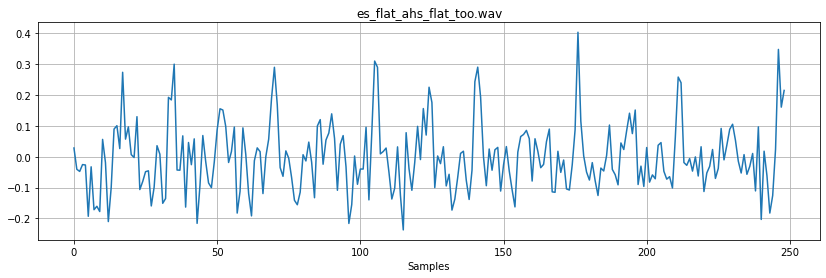

Lowest "Strong" Frequencies: [35, 35, 53, 17, 18, 177, 176, 35, 17, 36, 15]
Median Frequency: 35.0
Estimated BPM: 75.6
--------------------------------------------------


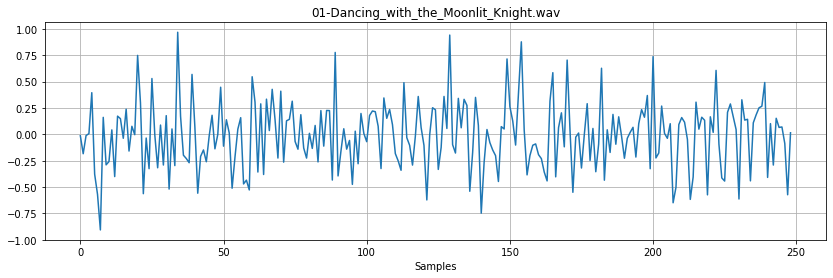

Lowest "Strong" Frequencies: [1, 1, 95, 162, 49, 35, 5, 75, 63, 36, 49]
Median Frequency: 49.0
Estimated BPM: 108.0
--------------------------------------------------


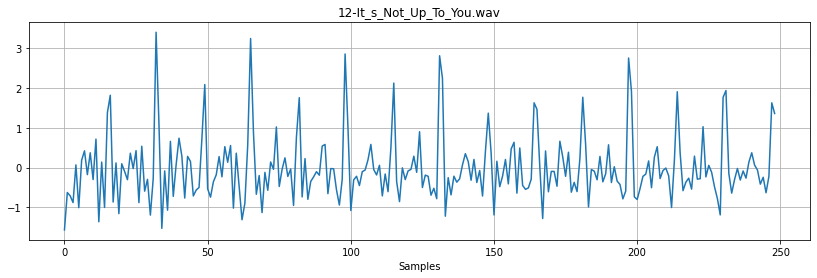

Lowest "Strong" Frequencies: [33, 33, 33, 99, 99, 33, 33, 116, 16, 116, 16]
Median Frequency: 33.0
Estimated BPM: 80.18
--------------------------------------------------


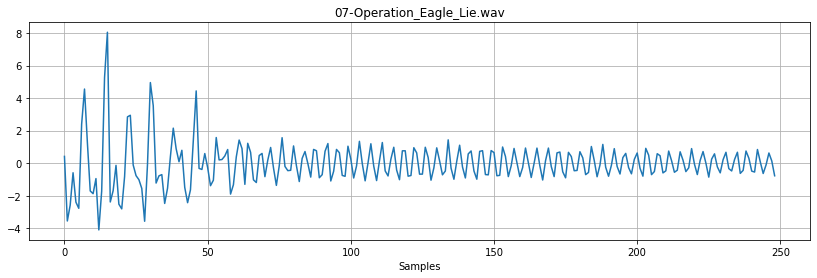

Lowest "Strong" Frequencies: [16, 16, 16, 16, 16, 16, 4, 4, 4, 17, 12]
Median Frequency: 16.0
Estimated BPM: 82.69
--------------------------------------------------


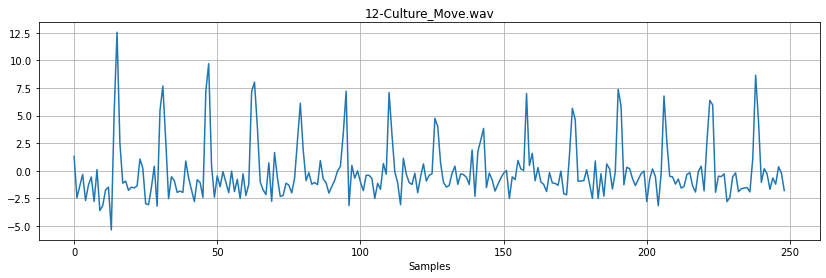

Lowest "Strong" Frequencies: [16, 16, 16, 16, 16, 16, 80, 16, 16, 96, 39]
Median Frequency: 16.0
Estimated BPM: 82.69
--------------------------------------------------


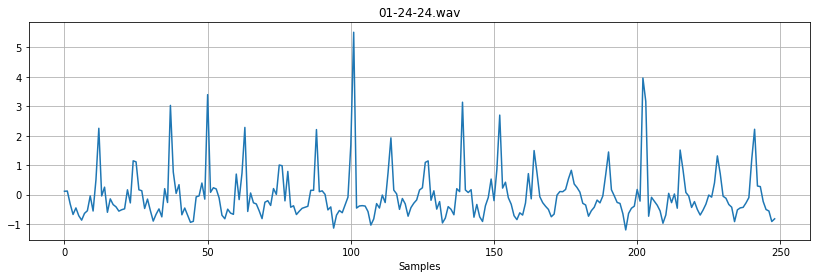

Lowest "Strong" Frequencies: [102, 102, 102, 102, 102, 102, 102, 102, 203, 102, 51]
Median Frequency: 102.0
Estimated BPM: 103.76
--------------------------------------------------


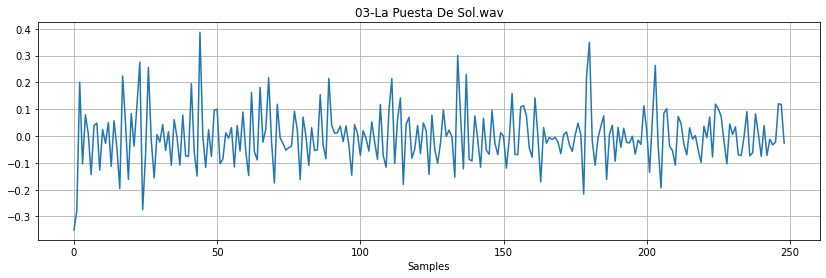

Lowest "Strong" Frequencies: [45, 68, 181, 45, 23, 45, 3, 180, 68, 68, 45]
Median Frequency: 45.0
Estimated BPM: 117.6
--------------------------------------------------


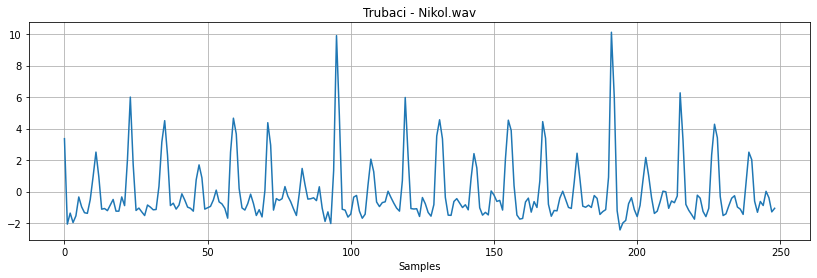

Lowest "Strong" Frequencies: [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 36]
Median Frequency: 96.0
Estimated BPM: 110.24
--------------------------------------------------


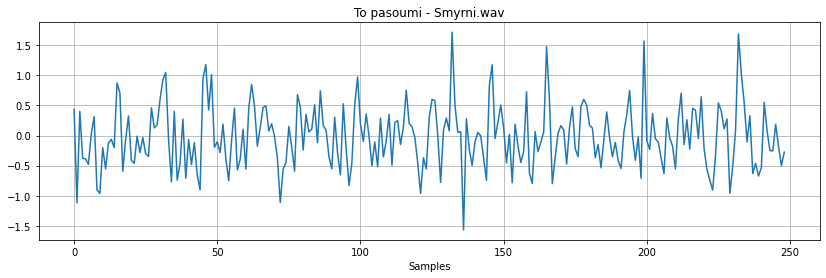

Lowest "Strong" Frequencies: [104, 226, 37, 66, 49, 133, 67, 130, 33, 133, 2]
Median Frequency: 67.0
Estimated BPM: 78.98
--------------------------------------------------


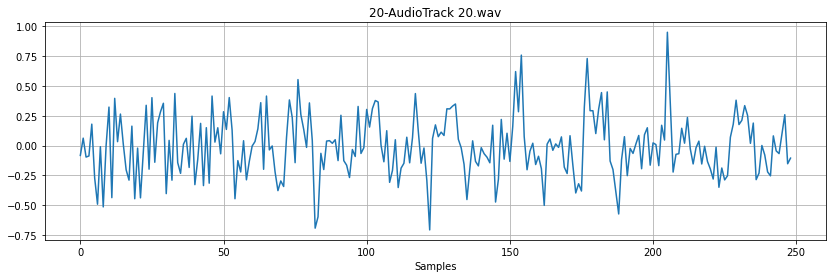

Lowest "Strong" Frequencies: [52, 25, 52, 15, 2, 206, 206, 51, 102, 52, 51]
Median Frequency: 52.0
Estimated BPM: 101.76
--------------------------------------------------


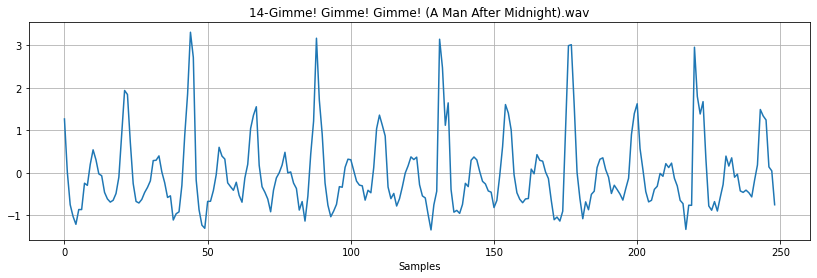

Lowest "Strong" Frequencies: [45, 45, 46, 46, 178, 45, 224, 224, 44, 44, 45]
Median Frequency: 45.0
Estimated BPM: 117.6
--------------------------------------------------


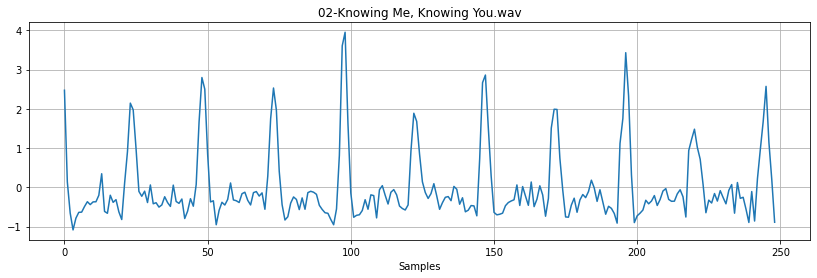

Lowest "Strong" Frequencies: [100, 101, 125, 49, 197, 98, 24, 24, 49, 13, 50]
Median Frequency: 50.0
Estimated BPM: 105.84
--------------------------------------------------


In [ ]:
BLOCKLEN = 1000
HOPLEN = 500
estimated_bpm = []

for i in range(len(song_list)):
  T_BLOCKLEN = 500
  T_HOPLEN = int(T_BLOCKLEN/3)
  MAX_THRESH = 0.2
  fund_frequencies = []

  # Finding onsets for each audio file by blocks
  onset, blockstart = onsetDetector(song_list[i], BLOCKLEN, HOPLEN)

  # Generating tempograms for each onset dataset
  tempogram = gen_tempogram(onset, T_BLOCKLEN, T_HOPLEN)

  # Finding the maximum AC spike beyond the 0th sample, and collecting spikes within a threshold (such as 80% of maximum)
  for j, AC in enumerate(tempogram):
    max = np.max(AC[1:])
    maximums = np.nonzero((AC > max - max*MAX_THRESH))

    # Plotting a sample autocorrelated novelty function
    if j == 5:
      plt.figure(figsize=(14, 4))
      plt.plot(AC[1:])
      plt.title(song_names[i])
      plt.xlabel('Samples')
      plt.grid()
      plt.show()

    # The large spike located at the 0th sample per block is not taken into account when
    # the smallest AC spike is located
    if maximums[0][0] == 0:
      fund_frequencies.append(np.min(maximums[0][1:]))


  # The median value of the smallest AC spike across all the blocks per audio is taken
  # The median value is perferred due to large outliers which sometimes arise depending on an abnormal block (as in the beginning or end of the audio)
  med_freq = np.median(fund_frequencies)
  # BPS is calculated by dividing sampling frequency by the sample number location of the AC spike
  # BPM is then found by multiplying by 60
  bpm = np.round(Fs / (med_freq*BLOCKLEN) * 60, 2)
  bpm = modulo_bpm(bpm)

  print(f'Lowest \"Strong\" Frequencies: {fund_frequencies}')
  print(f'Median Frequency: {med_freq}')
  print(f'Estimated BPM: {bpm}')
  print('--------------------------------------------------')
  estimated_bpm.append(bpm)

# Tempo Detection (Using Librosa)

Use the Librosa library to calculate tempos for each audiofile given

In [ ]:
import librosa
import librosa.display

In [ ]:
def librosa_temp_det(file):

  #get file and load waveform into variable
  y = es.MonoLoader(filename=file, sampleRate=Fs)()

  #calculate the tempo of the file using librosa
  tempo_spect_flux = librosa.beat.tempo(y, sr=Fs)
  return tempo_spect_flux

#initialize empty list for librosa calculated tempos
librosa_bpm = np.zeros((len(song_list),))

#initialize empty list for human annotated tempo
human_bpm = np.zeros((len(song_list),))

#Loading bpm values calculated by Librosa, and human annotated values into their lists
for i, file in enumerate(audio_files):
  print(file)
  librosa_bpm[i] = round(librosa_temp_det(file)[0], 2)
  tempo_file = file[:len(file) - 4] + " beat.bpm"
  with open(tempo_file, 'r') as f:
    human_bpm[i] = round(float(f.read()), 2)

/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/es_flat_ahs_flat_too.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/01-Dancing_with_the_Moonlit_Knight.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/12-It_s_Not_Up_To_You.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/07-Operation_Eagle_Lie.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/12-Culture_Move.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/01-24-24.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/03-La Puesta De Sol.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/Trubaci - Nikol.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/To pasoumi - Smyrni.wav
/content/drive/Shareddrives/ECE160-Visell-2022/Media Files/tempo_dataFolder/20-AudioTrack 20.wav
/

# Data Visualization

Chart specifying the calculated tempo by our algorithm, the calculated tempo by the Librosa library, the human annotated tempo, and the difference between the tempo calculated by our algorithm and the annotated tempo for each of the files given

In [ ]:
import pandas as pd

data = np.zeros((len(song_list), 4))

# Data is reorganized to be placed into a tabular format, percent difference is also calculated
for i in range(len(human_bpm)):
  difference = round(100*abs(estimated_bpm[i] - human_bpm[i]) / human_bpm[i], 2)
  data[i] = [estimated_bpm[i], librosa_bpm[i], human_bpm[i], difference]

df = pd.DataFrame(data, index=song_names, columns=['Estimated BPM', 'Librosa BPM', 'Human-Annotated BPM', 'Percent Difference'])

display(df)

NameError: ignored

Plot points specifying the calculated tempo by our algorithm, the calculated tempo by the Librosa library, and the human annotated tempo for each of the files given

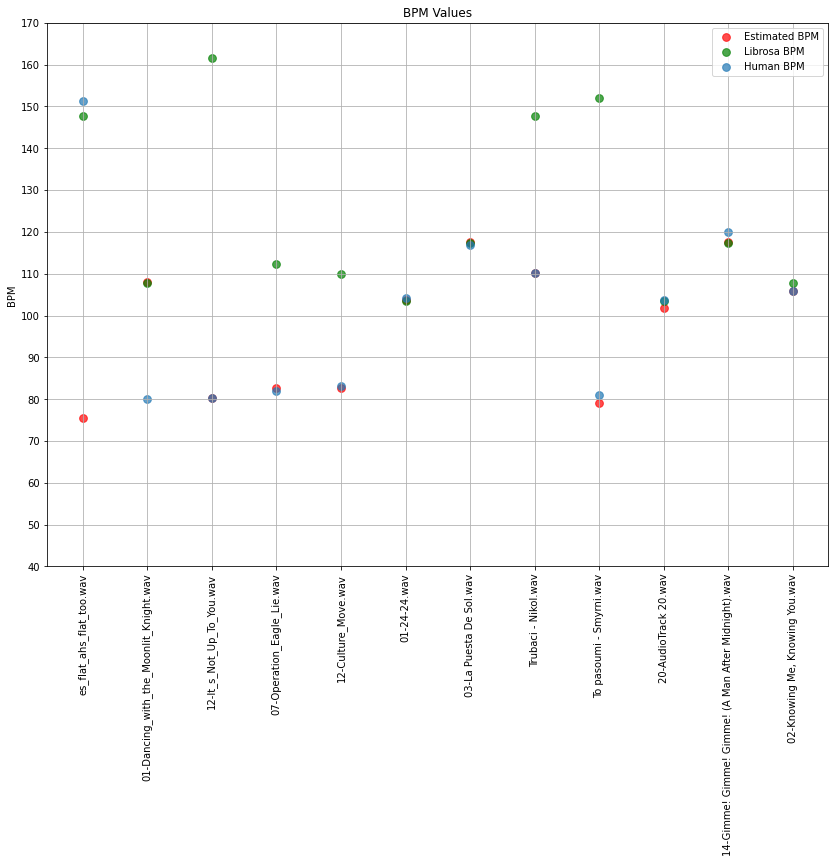

In [ ]:
x = range(len(song_names))

plt.figure(figsize=(14, 10))
plt.scatter(x, estimated_bpm, label='Estimated BPM', color='r', s=60, alpha=0.7)
plt.scatter(x, librosa_bpm, label='Librosa BPM', color='g', s=60, alpha=0.7)
plt.scatter(x, human_bpm, label='Human BPM', s=60, alpha=0.7)
plt.title('BPM Values')
plt.ylabel('BPM')
plt.xticks(ticks=np.arange(0, 12, 1), labels=song_names, rotation=90)
plt.yticks(np.arange(40, 180, 10))
plt.grid()
plt.legend()
plt.show()

Plot the waveform of each audio file given, and plot vertical lines on each beat calculated by our tempo detection algorithm

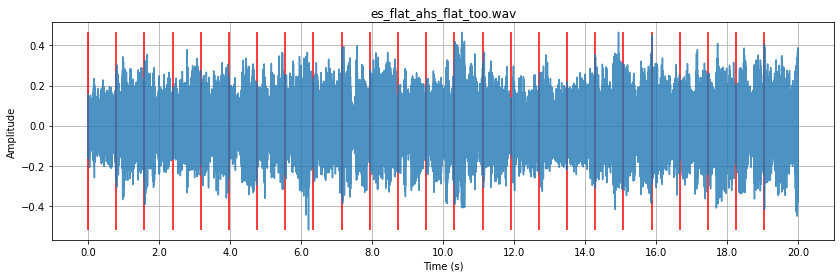

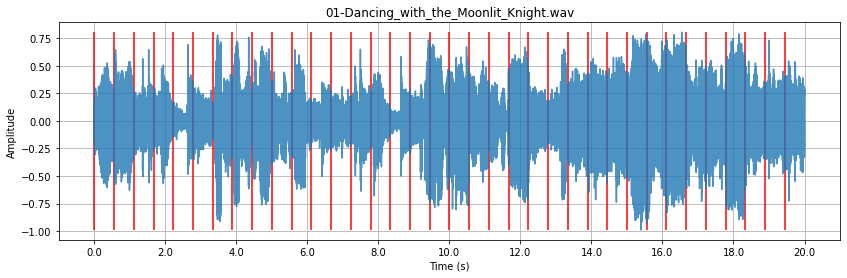

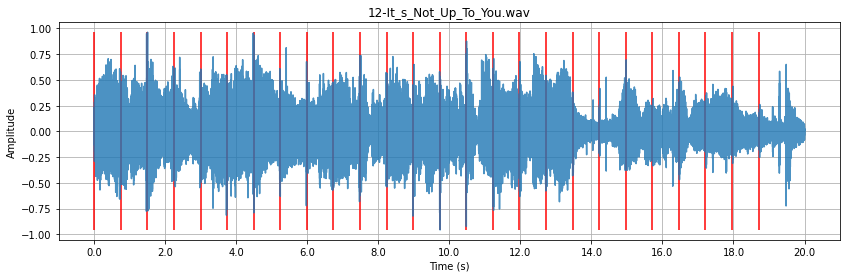

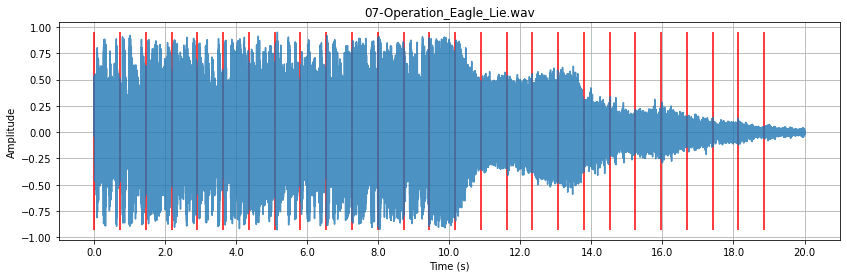

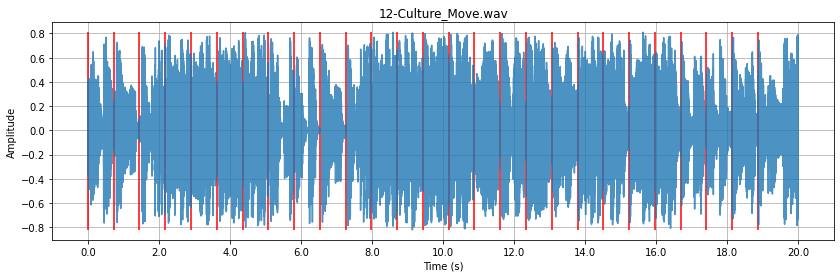

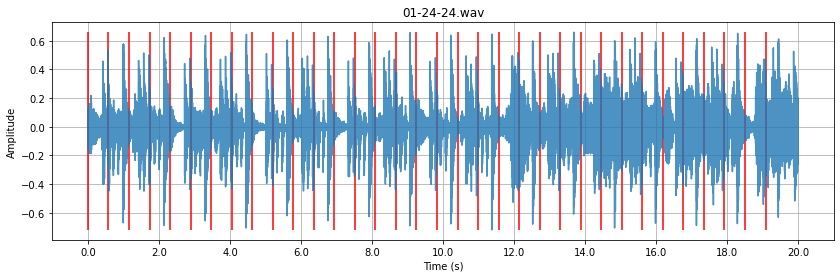

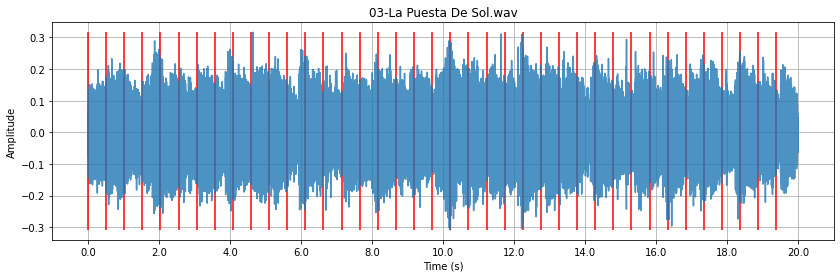

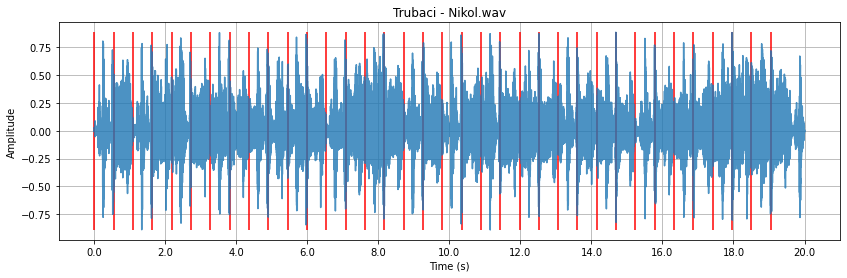

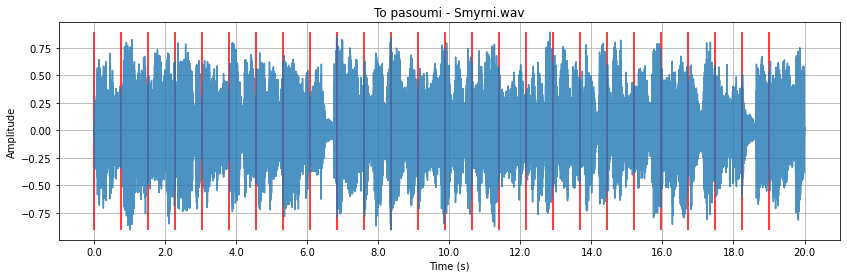

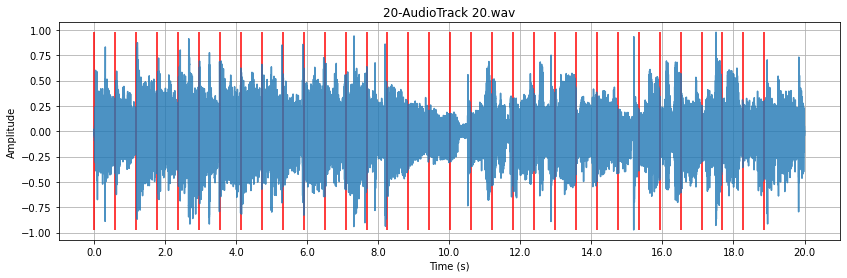

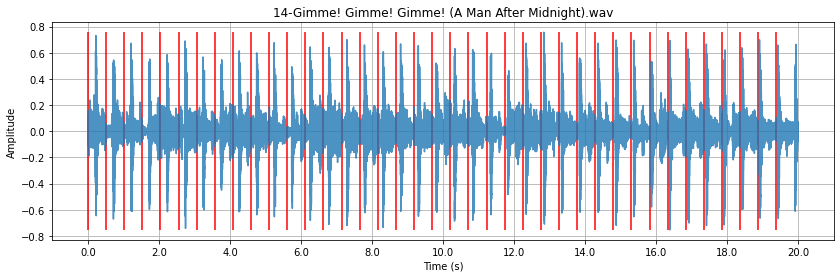

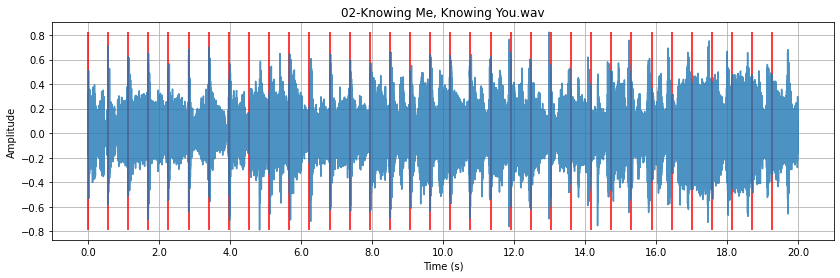

In [ ]:
for k, file in enumerate(audio_files):
  #load current audio recording through essentia
  song = es.MonoLoader(filename=file, sampleRate=Fs)()

  #get the time domain value for each sample
  n_samples = song.shape[0]
  tt = np.arange(0,n_samples*Ts,Ts)

  #find the estimated beat intervals
  beat_interval_seconds = estimated_bpm[k] / 60
  beat_interval_samples = Fs / beat_interval_seconds

  #find the line locations at every beat interval
  line_locations = [int(m*beat_interval_samples) for m in range(int(n_samples / beat_interval_samples))]

  #plot the audio signal waveform for the current audio file along with the vertical lines
  plt.figure(figsize=(14, 4))
  plt.title(song_names[k])
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.grid()
  plt.plot(song[:len(tt)], alpha=0.8)
  plt.vlines(x=line_locations, ymin=np.min(song), ymax=np.max(song), color='r')
  plt.xticks(np.arange(0, (n_samples + Fs), n_samples/10), np.arange(0, (n_samples + Fs)*Ts, np.round(n_samples/10*Ts, 1)))
  plt.show()

# Discussion

The novelty function utilized in this implementation was the block-by-block spectral flux. The spectral flux of each block was then auto correlated with itself, and the outcomes were produced into tempograms. The frequency distinction varied depending on the audio file, with some showing dominant peaks at various harmonics, and others showing a less prominent distinction. Various parameters such as tempogram block length, and block overlap were changed in order to provide a result which encompassed an overall increase in tempogram resolution.
 
<br>
 
The prominent peaks were then extracted from each tempogram block by finding the maximum spike, and collecting all spikes within a percentage of the maximum. At this point, each tempogram block had a corresponding array of  spikes containing various harmonics of the beat interval. Figures 1 and 2 depict two cases from two different audio files which show a clear tempogram with prominent peaks, and a tempogram that provides little distinguishability. The peaks that were picked out by the algorithm which fall within the threshold are marked.

<center>

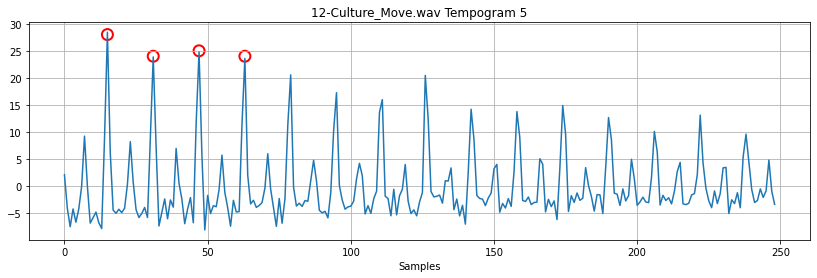

Figure 1. A prominant tempogram with extracted peaks.

</center>

<center>

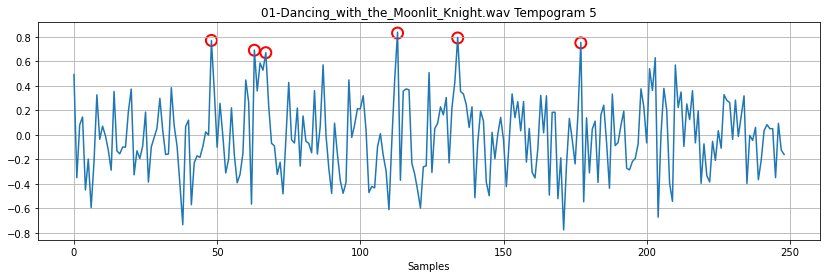

Figure 2. A less prominant tempogram with extracted peaks.
</center>

The minimum spike of each tempogram block was collected, and the median value for minimum spikes was found across all the tempogram blocks to represent the beat interval for each audio file. The median value was then decompressed to its sample value in the audio file, and a conversion was taken to find the corresponding BPM.
 
<br>
 
Initially, we had an issue with the calculated BPM when comparing the values from our algorithm to the human-annotated BPM values. The vast majority of the BPM values we were getting were multiples of the actual BPM values, which fell into uncommon ranges that are typical of music. We produced a final modulo function that took our calculated BPM value, and checked to see if the BPM fell within the range of modern music (typically between 60 and 150 BPM). The modulo function would either multiply or divide the BPM until it fell within the appropriate range.
 
<br>
 
The results were extremely accurate after this final tweak, with the vast majority of the audio files falling within 3% of the human-annotated values. An unfortunate drawback to this implementation was that in the example for the first audio file, the algorithm originally correctly calculated the BPM. The calculated BPM was on the cusp of the upper limit for typical audio, and divided the final value by 2, producing a 50% discrepancy. Because this modulo operation produced better results for many other audio files, we decided the tradeoff was worth the occasional fault and focused more on providing accurate results for typical music BPM. 